# Mathematics behind the radial time graphs

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

In [3]:
cmap_cones = 'viridis_r'

---

(this is copied directly from the geography notebook)

# Define travel time grids

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

+ IVT centre: (0, 0)
+ IVT/MT centre: (0, $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$)

In [4]:
time_travel_ivt_to_mt = 50

In [5]:
ivt_coords = [0, 0]
mt_coords  = [0, -time_travel_ivt_to_mt]

Change these parameters:

In [6]:
# Only calculate travel times up to this x or y displacement:
time_travel_max = 120

# Change how granular the grid is. 
grid_step = 1 # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Define a helper function to build the time grid:

In [7]:
def make_time_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.arange(-xy_max, xy_max + step, step) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking rows (xx) and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Build the grids:

In [8]:
grid_time_travel_directly_to_ivt = make_time_grid(
    grid_xy_max, grid_step, x_offset=ivt_coords[0], y_offset=ivt_coords[1])

grid_time_travel_directly_to_mt = make_time_grid(
    grid_xy_max, grid_step, x_offset=mt_coords[0], y_offset=mt_coords[1])

grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

In [9]:
extent = [-grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5, 
          -grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5] 

---

## Plot travel times

### Grids

In [10]:
from outcome_utilities.geography_plot import plot_two_grids_and_diff

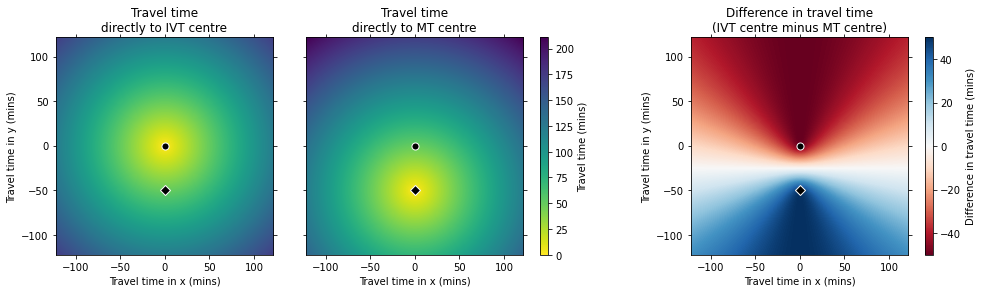

In [11]:
titles = [
    'Travel time'+'\n'+'directly to IVT centre', 
    'Travel time'+'\n'+'directly to MT centre', 
    'Difference in travel time'+'\n'+'(IVT centre minus MT centre)'
    ]

cbar_labels = [
    'Travel time (mins)', 
    'Difference in travel time (mins)'
    ]

plot_two_grids_and_diff(
    grid_time_travel_directly_to_ivt, 
    grid_time_travel_directly_to_mt, 
    grid_time_travel_directly_diff,
    titles=titles, cbar_labels=cbar_labels, 
    extent=extent, cmaps=['viridis_r', 'RdBu'],
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

On the difference grid, positive values are nearer the IVT/MT centre and negative nearer the IVT-only centre. There is a horizontal line halfway between the two treatment centres that marks where the travel times to the two treatment centres are equal. 

---

(new stuff!)

# Reinterpreting the time maps

To make it easier to see where the curves come from, we can imagine that the grids are already plotted in three dimensions. The x and y are the same, just travel time from the centre. In the previous chart we've drawn the distance from the centre by colouring the grid, but we could instead define a z-axis and plot farther-away values as higher up the axis.

In [12]:
levels = np.linspace(0.0, time_travel_max, 100)

In [13]:
colours_levels = plt.get_cmap(cmap_cones)(np.linspace(0,1,len(levels)))[1:]

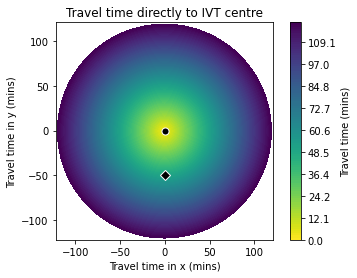

In [14]:
# Travel directly to IVT centre
# Contourf shows over and under values as white. 
plt.contourf(grid_time_travel_directly_to_ivt, origin='lower', 
             extent=extent, vmin=0, vmax=time_travel_max,
             levels = levels,
            cmap=cmap_cones)
plt.colorbar(label='Travel time (mins)')
plt.title('Travel time directly to IVT centre')

# Mark the treatment centre locations:
plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
            color='k', edgecolor='w', s=50)

plt.xlabel('Travel time in x (mins)')
plt.ylabel('Travel time in y (mins)')

plt.gca().set_aspect('equal')
plt.show()

Define (x,y,z) coordinates for each colour level in the cone.

In [15]:
n_coords    = 45
cone_angles = np.linspace(0.0, 2.0*np.pi, n_coords)

In [16]:
def make_cone_coords(levels, cone_angles_all):
    cone_coords = [] 
    for l, level in enumerate(levels):
        if cone_angles_all.ndim > 1:
            cone_angles = cone_angles_all[l]
        else:
            cone_angles = cone_angles_all
            
        x = level*np.cos(cone_angles)
        y = level*np.sin(cone_angles)
        z = np.full(x.shape, level)
        cone_coords.append([x,y,z])

    # Creating an object array messes up the trisurf later
    # cone_coords = np.array(cone_coords, dtype=object)
    return cone_coords

In [17]:
cone_coords = make_cone_coords(levels, cone_angles)

Define a function for plotting:

In [18]:
def draw_cone_3d(ax, levels, cone_coords, colours_levels):

    for i in range(1,len(levels)):
        ax.plot(cone_coords[i][0], cone_coords[i][1], cone_coords[i][2], 
                color=colours_levels[i-1], linewidth=3.0, zorder=3)
    
    ax.set_xlabel('Travel time in x (mins)') 
    ax.set_ylabel('Travel time in y (mins)') 
    ax.set_zlabel('Travel time (mins)') 
    
    ax.set_zlim(0, time_travel_max)
    return ax

Plot some cones:

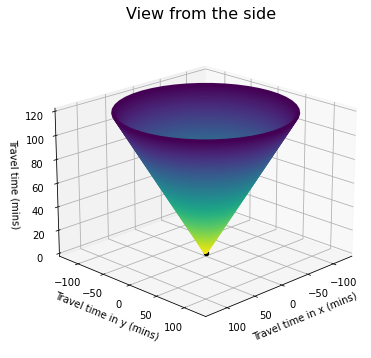

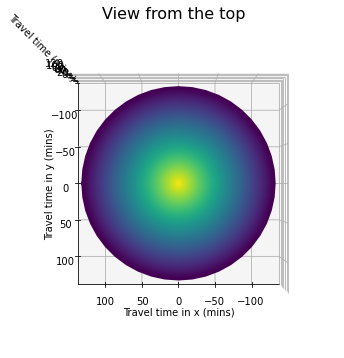

In [19]:
viewing_angles_list = [[45,20], [90,90]]
titles_list = ['View from the side', 'View from the top']

for v,(azim, elev) in enumerate(viewing_angles_list):
    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(projection='3d', azim=azim, elev=elev)
    draw_cone_3d(ax, levels, cone_coords, colours_levels)
    # Mark the origin: 
    ax.scatter(0,0,0, color='k', marker='o')
    ax.set_title(titles_list[v], fontsize=16)
    plt.show()

n.b. the axis limits don't appear to exactly match the 2D imshow plot. This is just because of matplotlib's 3D projection - the z-axis sticks out of the page a bit instead of being flattened. 

---

# Slicing through the cone

To find the variation in (time distance from the origin) for a slice along the y-axis (fixed x), can look at it as slice through the cone. 

Imports for the rectangle slice:

In [20]:
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Rectangle

In [21]:
xcut_list = [0, 30, 60]

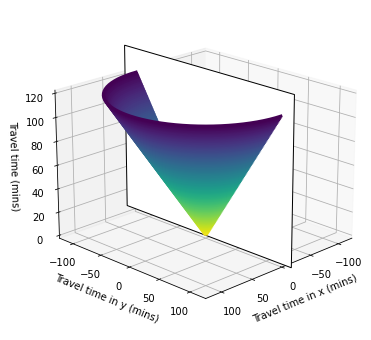

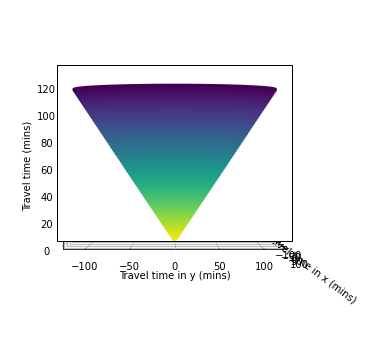

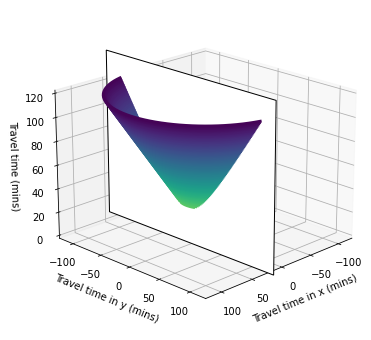

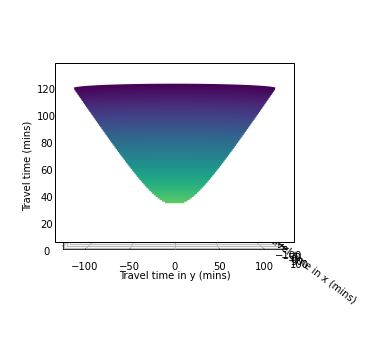

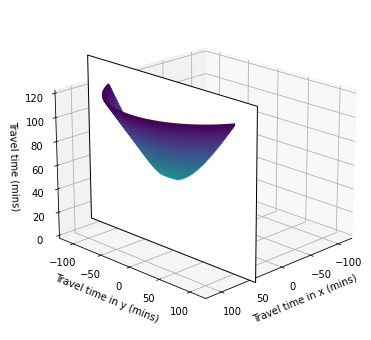

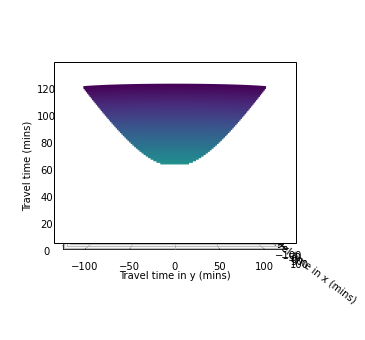

In [22]:
for xcut in xcut_list:
    for (azim, elev) in [[45,20], [0,0]]:
        fig = plt.figure(figsize=(6,6))
        ax  = fig.add_subplot(projection='3d', azim=azim, elev=elev)

        # Draw a slicing rectangle: 
        p = Rectangle((-time_travel_max-20, 0), 2.0*(time_travel_max+20), time_travel_max+20, facecolor='w', edgecolor='k', zorder=1)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=xcut, zdir='x')

        # Only draw the lines between the observer and the slice. 
        # (3d plotting doesn't clip the shapes in zorder like I'd hoped.)
        cone_angles_cuts_all = []
        plot_levels = []
        plot_colours = []
        for l, level in enumerate(levels):
            if level>=xcut:
                plot_levels.append(level)
                if level!=0.0:
                    plot_colours.append(colours_levels[l-1])
                    angle_max = np.arccos(xcut/level)
                    cone_angles = np.linspace(-angle_max, angle_max, n_coords)
                else:
                    cone_angles = np.full(n_coords, 0.0)
                cone_angles_cuts_all.append(cone_angles)
        cone_angles_cuts_all = np.array(cone_angles_cuts_all, dtype=float)



        cone_coords_cuts = make_cone_coords(plot_levels, cone_angles_cuts_all)

        draw_cone_3d(ax, plot_levels, cone_coords_cuts, plot_colours)


        ax.set_xlim(-time_travel_max, time_travel_max)
        ax.set_ylim(-time_travel_max, time_travel_max)
        # ax.set_title('View from the side', fontsize=16)
        plt.show()

See a curved shape in z along the slice. (It's a straight line only through the very centre of the cone). 

# Hyperbola

The shape of this [conic section](https://en.wikipedia.org/wiki/Conic_section) parallel to the axis of the cone is a [hyperbola](https://en.wikipedia.org/wiki/Hyperbola). The formula for a hyperbola through a right cylindrical cone like our time cone is:

$$ \frac{z^2 - y^{2}}{a^2} = 1 $$

for $a$, the fixed value of $x$ that we've sliced through. 

Rearranging:

$$ z = \sqrt{a^2 + y^2} $$

We can plot these values of $z$ and $y$ for the same slices that we've just made through the cone. 

In [23]:
def plot_hyperbolae(levels, colours_levels, xcut_list, time_travel_max):
    # Add background colours:
    for i,level in enumerate(levels[1:]): 
        plt.fill([-level,-levels[i-1],levels[i-1],level],
                         [level,levels[i-1],levels[i-1],level],
                         color=colours_levels[i-1], alpha=0.5)

    # Draw hyperbolae:
    linestyles=['--', '-.', '-']
    for i, xcut in enumerate(xcut_list):
        y = np.linspace(-time_travel_max, time_travel_max, 100)
        z = np.sqrt(xcut**2.0 + y**2.0)

        plt.plot(y,z, label=f'a={xcut}', color='k', linestyle=linestyles[i])


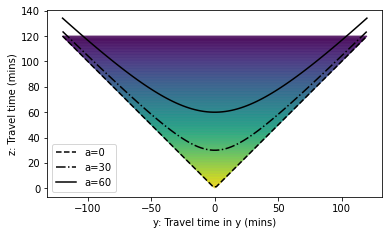

In [24]:
plot_hyperbolae(levels, colours_levels, xcut_list, time_travel_max)
plt.xlabel('y: Travel time in y (mins)')
plt.ylabel('z: Travel time (mins)')
plt.legend()
plt.gca().set_aspect('equal')

The minimum of each curve is at $(y=0, z=a)$.

As a sanity check, we can pull out the actual distances from the original grid and compare them with these curves:

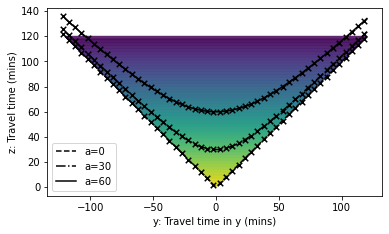

In [25]:
plot_hyperbolae(levels, colours_levels, xcut_list, time_travel_max)

# markers = ['+', 'x', '*']
for i,xcut in enumerate(xcut_list):      
    # Pull out the data from the grid:
    y_grid = np.arange(-grid_xy_max, grid_xy_max+grid_step, grid_step)
    z_grid = grid_time_travel_directly_to_ivt[np.where(y_grid==xcut)[0][0],:]
    # Use [::5] to only plot every fifth point. Too many otherwise. 
    plt.scatter(y_grid[::5], z_grid[::5], color='k', s=30, 
                marker='x',#markers[i], 
                zorder=3)#, label=f'a={xcut}: grid')
    
plt.xlabel('y: Travel time in y (mins)')
plt.ylabel('z: Travel time (mins)')
plt.legend()
plt.gca().set_aspect('equal')

---

# Difference in time

Using the formula for a hyperbola, we can work out why the time difference grid looks so weird. (not a technical term) 

Time passes equally at both treatment centres. In terms of our grids, the IVT/MT centre has an offset of `time_travel_ivt_to_mt` in the y-direction. I'm arbitrarily calling this $t_d$. The formula for time to this centre is:

$$ \frac{z^2 - (y+t_d)^{2}}{a^2} = 1 $$

$$ z = \sqrt{a^2 + (y+t_d)^2} $$

We can plot both time cones on the same axes: 

In [26]:
def make_hyperbolic_z(y, a, y_offset=0.0):
    return np.sqrt(a**2.0 + (y+y_offset)**2.0)

We want to take the difference between the two sets of times. This is more easily represented by plotting (minus cone 2), and then we can sum (cone 1) and (minus cone 2). 

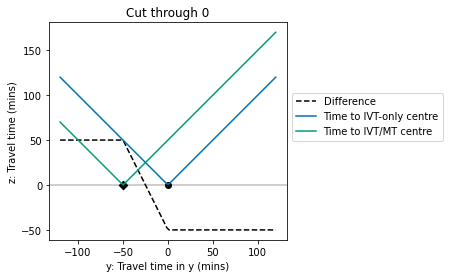

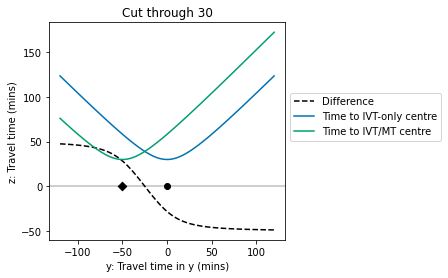

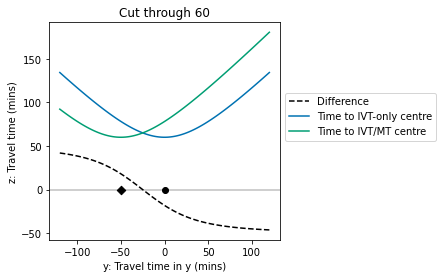

In [27]:
y = np.linspace(-time_travel_max, time_travel_max, 100)

for xcut in xcut_list:
    # Define the time cones along this "a" (cut through x):
    z_ivt_only = make_hyperbolic_z(y, xcut)
    z_ivt_mt   = make_hyperbolic_z(y, xcut, y_offset=time_travel_ivt_to_mt)
    
    plt.axhline(0, color='silver', zorder=0)

    # Also plot the difference:
    plt.plot(y, z_ivt_only -z_ivt_mt, color='k', linestyle='--', label='Difference')

    # Draw the time cones:
    plt.plot(y, z_ivt_only, label='Time to IVT-only centre')
    plt.plot(y, z_ivt_mt, label='Time to IVT/MT centre')


    plt.xlabel('y: Travel time in y (mins)')
    plt.ylabel('z: Travel time (mins)')
    plt.legend(bbox_to_anchor=[1.0,0.5,0.2,0.2])
    plt.gca().set_aspect('equal')
    
    # Mark the centre locations:
    plt.scatter(0,0, marker='o', color='k', label='IVT-only centre')
    plt.scatter(-time_travel_ivt_to_mt, 0, marker='D', color='k', 
                label='IVT/MT centre')
    
    plt.title(f'Cut through {xcut}')
    plt.show()

Make lots of cuts and only plot the differences:

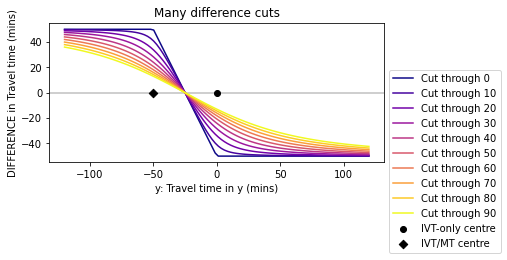

In [28]:
xcuts_lots = np.arange(0, 100, 10)#grid_xy_max, 10)
colours_lots = plt.get_cmap('plasma')(np.linspace(0,1,len(xcuts_lots)))

for i,xcut in enumerate(xcuts_lots):
    # Define the time cones along this "a" (cut through x):
    z_ivt_only = make_hyperbolic_z(y, xcut)
    z_ivt_mt   = make_hyperbolic_z(y, xcut, y_offset=time_travel_ivt_to_mt)

    # Plot the difference:
    plt.plot(y, z_ivt_only -z_ivt_mt, label=f'Cut through {xcut}', color=colours_lots[i])#
    #, color='k', linestyle='--', label='Difference')

# Mark the centre locations:
plt.scatter(0,0, marker='o', color='k', label='IVT-only centre')
plt.scatter(-time_travel_ivt_to_mt, 0, marker='D', color='k', 
            label='IVT/MT centre')

plt.xlabel('y: Travel time in y (mins)')
plt.ylabel('DIFFERENCE in Travel time (mins)')
plt.legend(bbox_to_anchor=[1.0,0.5,0.2,0.2])
plt.gca().set_aspect('equal')

plt.axhline(0, color='silver', zorder=0)
plt.title('Many difference cuts')
plt.show()

Looks like this is tending to flatness with very large x-offset from the two centres. Makes sense - if you're ages away in x, the difference in y hardly matters.

Also all of the differences go to zero at the point halfway between the centres. 

How do these curves match the ones from the earlier plot? 

Copied the cell from earlier: 

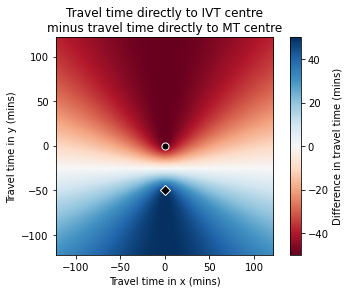

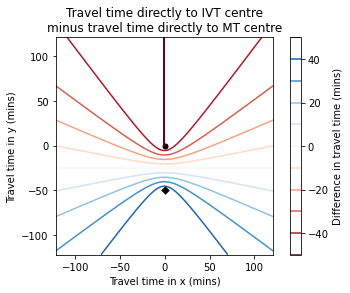

In [29]:
vmin = 0
vmax = np.max([grid_time_travel_directly_to_ivt,
               grid_time_travel_directly_to_mt])

for i in range(2,4):
        
    if i==2:
        # Difference grid 
        plt.imshow(grid_time_travel_directly_diff, origin='lower', 
                   extent=extent, cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        plt.title('Travel time directly to IVT centre'+'\n'+
                  'minus travel time directly to MT centre')
        
    elif i==3:
        # Difference contours
        plt.contour(grid_time_travel_directly_diff, origin='lower', 
                    extent=extent,
                    levels=np.arange(-50,60,10), cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        plt.title('Travel time directly to IVT centre'+'\n'+
                  'minus travel time directly to MT centre')
                
    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
                color='k', edgecolor='w', s=50)

    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')
    
    plt.gca().set_aspect('equal')
    plt.show()

Flatter new lines --> flatter old lines, slower change as you move up the grid. 

### Testing - to remove

(-3.141592653589793, 3.141592653589793)

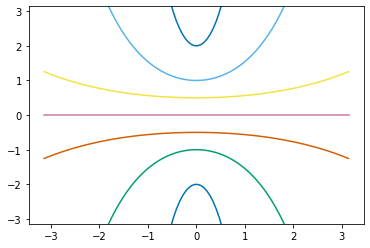

In [30]:
angles_test = np.linspace(-np.pi, np.pi, 100)

# plt.plot(angles_test, 0.5*np.cosh(angles_test))
# plt.plot(angles_test, np.cosh(angles_test))
# plt.plot(angles_test, 2.0*np.cosh(angles_test))

# plt.plot(angles_test, np.cosh(0.5*angles_test))
# plt.plot(angles_test, np.cosh(angles_test))
# plt.plot(angles_test, np.cosh(2.0*angles_test))

for i in [-2.0,-1.0,-0.5, 0.0, 0.5, 1.0, 2.0]:
    plt.plot(angles_test, i*np.cosh(i*angles_test))

plt.ylim(-np.pi, np.pi)

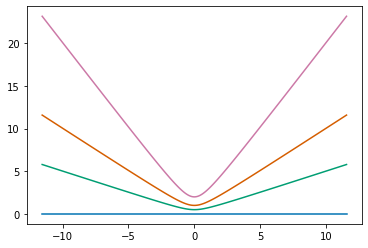

In [31]:
for i in [0.0, 0.5, 1.0, 2.0]:
    plt.plot(np.sinh(angles_test), i*np.cosh(angles_test))

In [32]:
def make_angle_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.copy(x_times) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking the rows (xx) 
    # and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    angles = np.arctan2(yy,xx)
    return angles

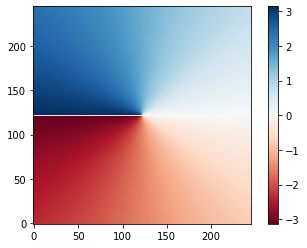

In [33]:
xy_angles = make_angle_grid(grid_xy_max, grid_step)

plt.imshow(xy_angles, origin='lower', cmap='RdBu')
plt.colorbar()
plt.show()

In [34]:
ycut = 0
x_angles = xy_angles[ycut,:]



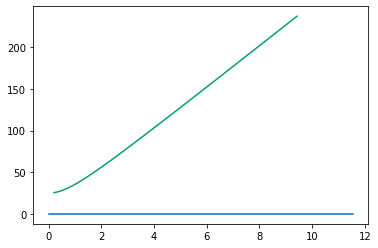

In [35]:
for ycut in [0,25]:#50,82]:
    x_angles = xy_angles[ycut+grid_xy_max,:]
    plt.plot(np.sinh(x_angles), 
             # x_angles,
             ycut*np.cosh(x_angles))

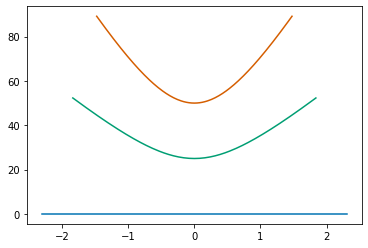

In [36]:
for xcut in [0,25,50]:
    y_angles = xy_angles[:,xcut+grid_xy_max]
    plt.plot(np.sinh(y_angles), 
             # x_angles,
             xcut*np.cosh(y_angles))

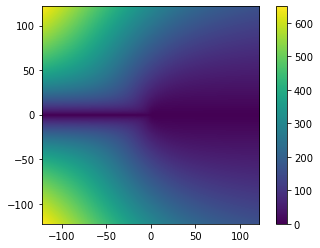

In [37]:
grid_new_diffs = np.full(grid_time_travel_directly_diff.shape, 0.0)

for ycut in np.arange(0, grid_new_diffs.shape[1], 1):
    x_angles = xy_angles[ycut,:]
    grid_new_diffs[ycut,:] = np.abs(ycut-grid_xy_max)* np.cosh(x_angles)
    
plt.imshow(grid_new_diffs, origin='lower', extent=extent)
plt.colorbar()
plt.show()

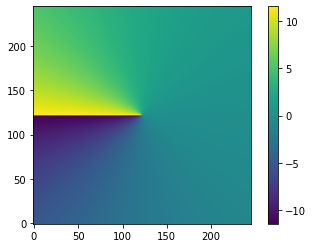

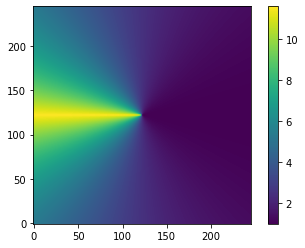

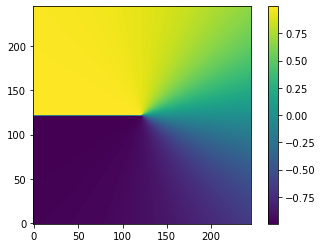

In [38]:
plt.imshow(np.sinh(xy_angles), origin='lower')
plt.colorbar()
plt.show()

plt.imshow(np.cosh(xy_angles), origin='lower')
plt.colorbar()
plt.show()


plt.imshow(np.tanh(xy_angles), origin='lower')
plt.colorbar()
plt.show()

### Comparison of x cuts


Very similar formulae:
    
    
$$ z = \sqrt{b^2 + x^2} $$


$$ z = \sqrt{(b+t_d)^2 + (x)^2} $$

where now $b$ is the fixed location of the cut through the x-axis. Fixed value of $y$. 

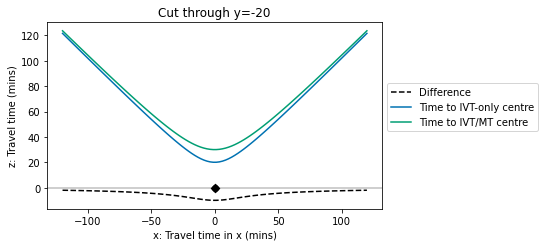

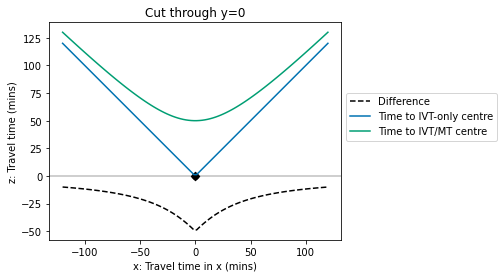

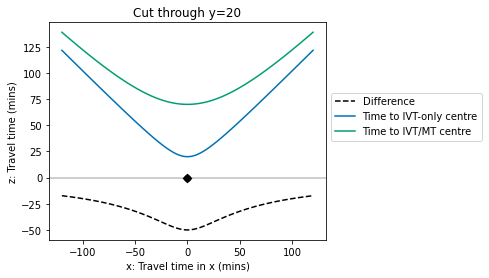

In [39]:
x = np.linspace(-time_travel_max, time_travel_max, 100)
ycut_list = [0, -time_travel_ivt_to_mt*0.5, time_travel_ivt_to_mt*0.5]

ycut_list = [-20,0,20]

for ycut in ycut_list:
    # Define the time cones along this "a" (cut through x):
    z_ivt_only = make_hyperbolic_z(ycut, x)
    z_ivt_mt   = make_hyperbolic_z(ycut, x, y_offset=time_travel_ivt_to_mt)

    plt.axhline(0, color='silver', zorder=0)

    # Also plot the difference:
    plt.plot(x, z_ivt_only -z_ivt_mt, color='k', linestyle='--', label='Difference')

    # Draw the time cones:
    plt.plot(x, z_ivt_only, label='Time to IVT-only centre')
    plt.plot(x, z_ivt_mt, label='Time to IVT/MT centre')


    plt.ylabel('z: Travel time (mins)')
    plt.legend(bbox_to_anchor=[1.0,0.5,0.2,0.2])
    plt.gca().set_aspect('equal')
    
    # Mark the centre locations:
    plt.scatter(0,0, marker='o', color='k', label='IVT-only centre')
    plt.scatter(0, 0, marker='D', color='k', 
                label='IVT/MT centre')
    
    plt.title(f'Cut through y={ycut}')
    plt.xlabel('x: Travel time in x (mins)')
    plt.show()

Basically end up comparing this slice through the cone with another slice much farther out. 

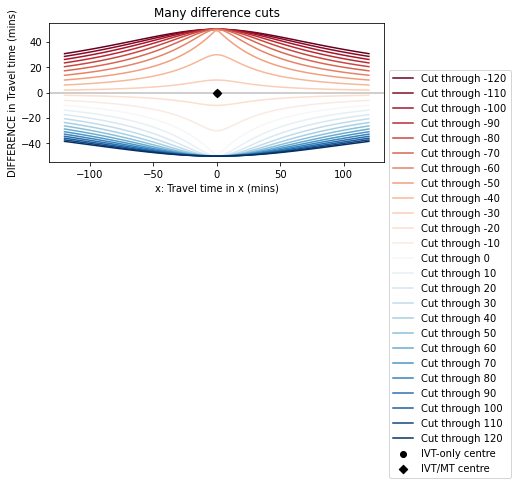

In [40]:
ycuts_lots = np.arange(-time_travel_max, time_travel_max+10, 10)#grid_xy_max, 10)
colours_lots = plt.get_cmap('RdBu')(np.linspace(0,1,len(ycuts_lots)))

for i,ycut in enumerate(ycuts_lots):
    # Define the time cones along this "a" (cut through x):
    z_ivt_only = make_hyperbolic_z(ycut, x)
    z_ivt_mt   = make_hyperbolic_z(ycut, x, y_offset=time_travel_ivt_to_mt)

    # Plot the difference:
    plt.plot(x, z_ivt_only -z_ivt_mt, label=f'Cut through {ycut}', color=colours_lots[i])#
    #, color='k', linestyle='--', label='Difference')

# Mark the centre locations:
plt.scatter(0,0, marker='o', color='k', label='IVT-only centre')
plt.scatter(0, 0, marker='D', color='k', 
            label='IVT/MT centre')

plt.xlabel('x: Travel time in x (mins)')
plt.ylabel('DIFFERENCE in Travel time (mins)')
plt.legend(bbox_to_anchor=[1.0,0.5,0.2,0.2])
plt.gca().set_aspect('equal')

plt.axhline(0, color='silver', zorder=0)
plt.title('Many difference cuts')
plt.show()

This doesn't look nice to find a formula for... 


$$ diff = \sqrt{b^2 + x^2} - \sqrt{(b+t_d)^2 + (x)^2} $$

Basically, what the curve's doing depends on how close $x$ is to $b$ or to $(b+t_d)$..?  

Not sure these scatter markers are correct

# 3D difference map

still mucking around

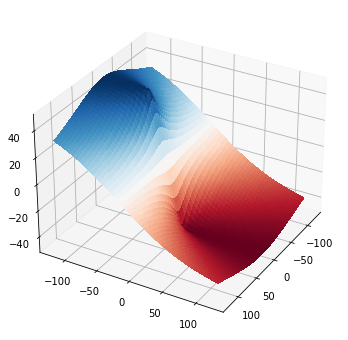

In [41]:
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(projection='3d', azim=30, elev=30)

# Make data.
X = np.arange(-grid_xy_max, grid_xy_max + grid_step, grid_step)
Y = np.arange(-grid_xy_max, grid_xy_max + grid_step, grid_step)
X, Y = np.meshgrid(X, Y)
Z = grid_time_travel_directly_diff

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=plt.get_cmap('RdBu'),
                       # edgecolor='k', linewidth=0.1, 
                       antialiased=False)


## Compare circles

In [44]:
def circle_coords(r, x0=0, y0=0, n_coords=90):
    thetas = np.linspace(0.0,2.0*np.pi, n_coords)
    x = r*np.sin(thetas) + x0
    y = r*np.cos(thetas) + y0
    return x,y

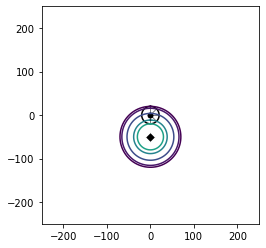

[70.0, 65.68267322797615, 53.85164807134504, 38.54590039974296, 30.0]
[1.         0.9383239  0.76930926 0.55065572 0.42857143]



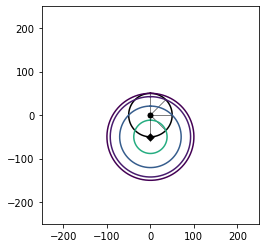

[100.0, 92.38795325112868, 70.71067811865476, 38.26834323650899, 6.123233995736766e-15]
[1.00000000e+00 9.23879533e-01 7.07106781e-01 3.82683432e-01
 6.12323400e-17]



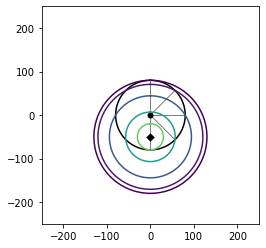

[130.0, 120.65178925110222, 94.33981132056604, 56.948623780628985, 30.0]
[1.         0.92809069 0.72569086 0.43806634 0.23076923]



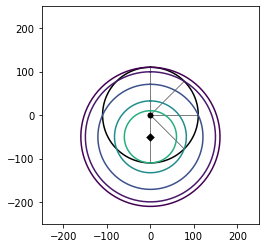

[160.0, 149.59336413441616, 120.83045973594572, 82.59434246331875, 60.0]
[1.         0.93495853 0.75519037 0.51621464 0.375     ]



In [60]:
for r1 in np.arange(20,120,30):
    # r1 = 30
    xc, yc = circle_coords(r1)
    plt.plot(xc,yc, color='k')

    r2_list = []
    for th in np.array([0.0,45.0,90.0,135.0,180.0])*np.pi/180.0:
        x_th = r1*np.sin(th)
        y_th = r1*np.cos(th)
        plt.plot([0,x_th],[0,y_th], color='k', linewidth=0.5)

        r2 = np.sqrt( (x_th)**2.0 + (time_travel_ivt_to_mt+y_th)**2.0)
        r2_list.append(r2)
        
        xc,yc = circle_coords(r2, y0=-time_travel_ivt_to_mt)

        colour = plt.get_cmap('viridis_r')(r2/(r1+time_travel_ivt_to_mt))

        plt.plot(xc,yc, color=colour)

    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
                color='k', edgecolor='w', s=50)

    plt.ylim(-250,250)
    plt.xlim(-250,250)    
    plt.gca().set_aspect('equal')
    plt.show()
    print(r2_list)
    print(np.array(r2_list)/np.max(r2_list))
    print()